In [1]:
%load_ext autoreload
%autoreload 2

from toolz import take
import torch as th
from torch.utils.data import DataLoader
from torch import tensor, optim, nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from wxml.model import MLP
from wxml.hamming import make_data_hamming, wt, bittensor, bittensor8, bitvector8, bin_to_dec
from wxml.data import make_splits
from wxml.train import train, count_matches

In [2]:
batch_size = 32
n_batches = 1000

xs, ys = make_data_hamming(batch_size * n_batches)

[print(xy) for xy in take(5, zip(xs, ys))]

ds_train, ds_val, ds_test = make_splits(xs, ys)
train_loader, val_loader, test_loader = [DataLoader(d, batch_size=batch_size, shuffle=False) for d in [ds_train, ds_val, ds_test]]

(tensor([0., 0., 1., 0., 0., 0., 0., 1.], requires_grad=True), tensor([0., 0., 0., 0., 0., 0., 1., 0.], requires_grad=True))
(tensor([0., 0., 1., 1., 0., 1., 1., 0.], requires_grad=True), tensor([0., 0., 0., 0., 0., 1., 0., 0.], requires_grad=True))
(tensor([0., 0., 1., 0., 1., 0., 0., 0.], requires_grad=True), tensor([0., 0., 0., 0., 0., 0., 1., 0.], requires_grad=True))
(tensor([0., 0., 1., 1., 1., 1., 1., 1.], requires_grad=True), tensor([0., 0., 0., 0., 0., 1., 1., 0.], requires_grad=True))
(tensor([0., 0., 1., 1., 0., 0., 1., 1.], requires_grad=True), tensor([0., 0., 0., 0., 0., 1., 0., 0.], requires_grad=True))


In [3]:
num_layers = 2
input_dim = 8
hidden_dim = 32
output_dim = 8

lr = 1e-3

epochs = 50

model = nn.Sequential(MLP(num_layers, input_dim, hidden_dim, output_dim), nn.Sigmoid())
opt = optim.Adam(model.parameters(), lr=lr)
loss_fn = F.binary_cross_entropy

results = train(model, loss_fn, opt, train_loader, val_loader, epochs=epochs, device='mps', dtype=th.float32, print_every=n_batches // 10)


  0%|          | 0/50 [00:00<?, ?it/s]

epoch=0 | train_loss=0.2426 | val_loss=0.1681 | train_acy=0.8810 | val_acy=0.9193
epoch=1 | train_loss=0.1527 | val_loss=0.1338 | train_acy=0.9342 | val_acy=0.9405
epoch=2 | train_loss=0.1129 | val_loss=0.0947 | train_acy=0.9599 | val_acy=0.9752
epoch=3 | train_loss=0.0822 | val_loss=0.0684 | train_acy=0.9770 | val_acy=0.9809
epoch=4 | train_loss=0.0557 | val_loss=0.0436 | train_acy=0.9883 | val_acy=0.9925
epoch=5 | train_loss=0.0341 | val_loss=0.0266 | train_acy=0.9978 | val_acy=1.0000
epoch=6 | train_loss=0.0206 | val_loss=0.0164 | train_acy=0.9997 | val_acy=1.0000
epoch=7 | train_loss=0.0125 | val_loss=0.0100 | train_acy=1.0000 | val_acy=1.0000
epoch=8 | train_loss=0.0076 | val_loss=0.0061 | train_acy=1.0000 | val_acy=1.0000
epoch=9 | train_loss=0.0046 | val_loss=0.0036 | train_acy=1.0000 | val_acy=1.0000
epoch=10 | train_loss=0.0027 | val_loss=0.0022 | train_acy=1.0000 | val_acy=1.0000
epoch=11 | train_loss=0.0016 | val_loss=0.0013 | train_acy=1.0000 | val_acy=1.0000
epoch=12 | tra

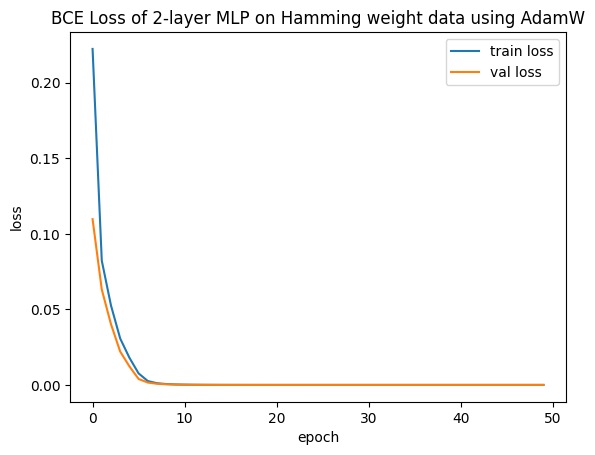

In [7]:
plt.plot(results['train_losses'], label='train loss')
plt.plot(results['val_losses'], label='val loss')
plt.title("BCE Loss of 2-layer MLP on Hamming weight data using AdamW")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

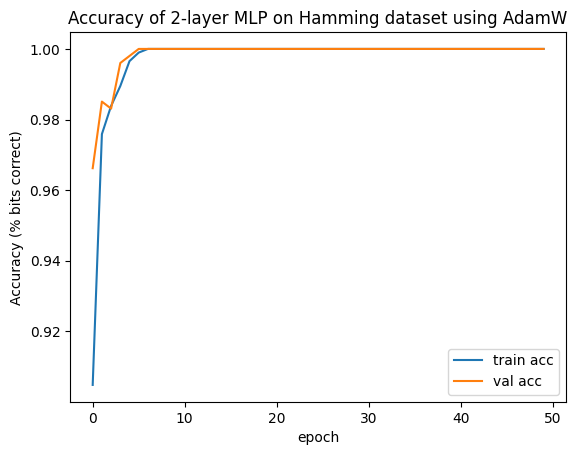

In [8]:
plt.plot(results['train_accuracies'], label='train acc')
plt.plot(results['val_accuracies'], label='val acc')
plt.title("Accuracy of 2-layer MLP on Hamming dataset using AdamW")
plt.ylabel("Accuracy (% bits correct)")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
count_matches(bittensor(wt(x), n=8).to('mps'), (model(x).round()))

In [ ]:
bin_to_dec([0, 0, 0, 0, 0, 0, 1, 1])

In [ ]:
def count_divisible(N, ps):
    acc = [0, 1]
    for i in range(2, N):
        if any(i % p == 0 for p in ps):
            acc.append(i)
    return acc

In [ ]:
n = 1000

def is_prime(x):
    return all(x % i != 0 for i in range(2, x))

def primes(n):
    acc = []
    i = 2
    while len(acc) < n:
        if is_prime(i):
            acc.append(i)
        i += 1
    return acc


acc = []
for i in range(n):
    acc.append(len(count_divisible(n, primes(i))))
    print(f"# primes: {i} | {acc[-1]}/{n}")

In [ ]:
plt.plot(acc)
plt.title("Number of numbers divisible by primes")
plt.xlabel("# primes")
plt.ylabel("# divisible")

In [ ]:
# TODO

def rounded(xs):
    return [round(x, 4) for x in xs]

def round01(x):
    return x.round()

th.set_printoptions(sci_mode=False, precision=4)

# x, bin(x), wt(bin(x)), bin(wt(bin(x))), f(x), round(f(x)), wt(round(f(x))), bin(wt(round(f(x))), n
print("x | bin(x) | wt(bin(x)) | bin(wt(bin(x))) | f(bin(x)) | round(f(x)) | base10(round(f(x))) | n")
for x in range(256):
    # bin_x = bittensor(x, 8).int().tolist()
    bin_x = bittensor8(x)
    wt_bin_x = wt(bin_x)
    bin_wt_bin_x = bittensor8(wt_bin_x)
    f_x = model(bin_x.to('mps'))
    round_f_x = round01(f_x)
    base10_round_f_x = bin_to_dec(round_f_x.int().tolist())
    n = 8 - count_matches(round_f_x.to('mps'), bin_wt_bin_x.to('mps'))
    print(f"{x} | {bin_x.int().tolist()} | {wt_bin_x.int().tolist()} | {bin_wt_bin_x.int().tolist()} | {rounded(f_x.tolist())} | {round_f_x.int().tolist()} | {base10_round_f_x} | {n}")

In [ ]:
# TODO: get accuracy for hamming weights not in train set
# TODO: make validation set contains hamming weights not in train set
# TODO: Hypothesis: the NN can only learn bitvectors up to a certain length

x = tensor([[0, 0, 0, 0, 0, 0, 1, 1]], device='mps').float()

th.set_printoptions(sci_mode=False)
with th.no_grad():
    print(model(x))